In [3]:
import numpy as np
import materials_propellant as mp
from scipy.integrate import quad
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Perараметры текста
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 12
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [4]:
# исходные данные
# основа основ
p0 = 17.5e6
# omega = 

nu_a = 17.611
lambda_a = 2.364



F_kr = 5.04 * 1e-3
D_kr = np.sqrt(4*F_kr/np.pi)
F_a = nu_a * F_kr
D_a = np.sqrt(4*F_a/np.pi)
# D_a = 0.356
#F_a = np.pi * D_a**2 / 4

# еще из 3 лабы
chi_tepl = 0.946

# параметры топлива
propellant  = mp.get_mixed_propellant('17% ПБКГ, 67% ПХА, 16% Al')

rho_t = propellant['rho_т']
R_t = propellant['R_г']
k = propellant['k']
T_0 = propellant['T_0']
mu_t = propellant['nu']
u_1t = propellant['u_1']
D_t = propellant['D_t']
u_t = lambda p: u_1t * (p / 1e6) ** mu_t
Q_zh = (k / (k - 1)) * R_t * T_0

# параметры заряда
e0 = 0.0323
D_v = 0.390
r = 0.006
n_zv = 8
L_zar = 2.863
# S_g = None

find_theta = lambda theta: np.pi/2 + np.pi/n_zv - theta - 1/np.tan(theta)
theta = fsolve(find_theta,np.deg2rad(35), xtol=1e-9)[0]

# другие параметры
p_n = 0.07012e6
K_a = 1 / 2 * (lambda_a + 1 / lambda_a)
K_inf = k / np.sqrt(k**2 - 1)
R_a = ((1 - ((k-1) / (k+1)) * lambda_a**2)**(1 / (k-1))) * (lambda_a**2 + 1) * F_a * p0
A_k = np.sqrt(k * ((2 / (k + 1)) ** ((k + 1) / (k - 1))))
G = (0.95 * A_k * p0 * F_kr) / (np.sqrt(chi_tepl * R_t * T_0))
R_inf = G * np.sqrt(2*chi_tepl*Q_zh)

In [5]:
propellant

{'Number': '13',
 'I_ud': 2670.5,
 'rho_т': 1702.0,
 'R_г': 449.147,
 'k': 1.27508,
 'T_0': 3093.81,
 'nu': 0.29,
 'u_1': 0.00426,
 'D_t': 0.002,
 'p_min': 500000.0}

In [6]:
def zvezda(D, L, e_0, n, theta, r):
    """Функция расчета горения заряда с каналом звездообразного сечения. Возвращает словарь с результатами и функции зависимостей \n
    площади поверхности горения заряда и параметра Победоносцева от толщины сгоревшего свода

    Args:
        D (float): внутренний диаметр КС
        L (float): длина заряда
        e_0 (float): толщина свода
        n (int): количество лучей звезды
        theta (float): полуугол выступа заряда
        r (float): радиус скругления

    Returns:
        dict: словарь результатов следующего типа:
            {
                'eps_f' (float): коэффициент заполнения поперечного сечения КС
                'kappa_0' (float): начальное значение параметра Победоносцева
                'ksi_degr' (float): массовая доля дегрессивных остатков
                'l' (float): длина заряда из условия размещения заданной массы топлива с учетом действительного заполнения
                'S_sr' (float): среднее значение плотногсти горения (с учетом дегрессивных остатков e = 0..e_0)
                'e_1': толщина сгоревшего свода в конце первой стадии
                'e_2': толщина сгоревшего свода в конце второй стадии
                'e_3': толщина сгоревшего свода в конце горения
            }
        S(e) (func): зависимость площади поверхности горения заряда от толщины сгоревшего свода
        kappa(e) (func): зависимость параметра Победоносцева от толщины сгоревшего свода
    """

    beta = np.pi / n
    R = D / 2 - e_0 - r
    F = 0.25 * np.pi * (D ** 2)
    
    # стадия 1
    alfa = (np.pi / 2) - theta + beta
    b = lambda e: R * ((np.sin(beta)) / (np.sin(theta))) - (r + e) * (1 / np.tan(theta))
    e_1 = R * (np.sin(beta) / np.cos(theta)) - r

    # стадия 2
    alfa2 = lambda e: beta + np.arcsin((R / (r+e)) * np.sin(beta))

    # стадия 3
    dalfa = lambda e: np.arccos(((D ** 2 / 4) - (R**2) - ((r + e)**2)) / (2 * R * (r+e)))
    alfa3 = lambda e: alfa2(e) - dalfa(e)
    e_3 = np.sqrt((D**2 / 4) + (R ** 2) - (D * R * np.cos(beta))) - r
    
    # периметр горения
    def Per(e):
        if e <= e_1:
            return 2 * n * (alfa * (r + e) + b(e))
        elif e <= e_0:
            return 2 * n * alfa2(e) * (r + e)
        elif e <= e_3:
            return 2 * n * alfa3(e) * (r + e)
        else:
            return 0
    
    # площадь горящего свода
    F_sv = lambda e: quad(Per, 0, e)[0]
    F_all = F_sv(e_3)
    F_0 = F_sv(e_0)
    
    # коэффициент заполнения
    eps_f = F_all / F
    
    # длина заряда
    # L = omega / (rho_t * F_all)
    # L_0 = omega / (rho_t * F_0)
    L_0 = L * F_all / F_0
    
    # площадь горения
    S = lambda e: Per(e) * L_0
    S_sr = quad(S, 0, e_0)[0] / e_0

    # kappa_0 = S(0) / (F * (1 - eps_f))
    # kappa = lambda e: S(e) / (F - (F_all - F_sv(e)))

    # e_mas = np.linspace(0,e_3+0.004, 500)
    # S_mas = np.array([S(e) for e in e_mas])
    # kappa_mas = np.array([kappa(e) for e in e_mas])
    
    # S = interp1d(e_mas,S_mas)
    # kappa = interp1d(e_mas,kappa_mas)
    
    # result = {
    #     'eps_f': eps_f,
    #     'kappa_0': kappa_0,
    #     'S_sr': S_sr,
    #     'e_1': e_1,
    #     'e_2': e_0,
    #     'e_3': e_3
    # }
    return S_sr

In [7]:
# эталоннное решение
S_g = zvezda(D_v,L_zar,e0,n_zv,theta,r)
S_g

9.748587287888258

In [8]:
def dP_P(dF_kr = 0, dF_a = 0, drho_t = 0, du1 = 0, dS = 0):
    """Функция определения статической чувствительности тяги

    Args:
        dF_kr (float, optional): Отклонение площади критики. Defaults to 0.
        dF_a (float, optional): Отклонение площади выходного сечения. Defaults to 0.
        drho_t (float, optional): Отклонение плотности топлива. Defaults to 0.
        du1 (float, optional): Отклонение единичной скорости горения. Defaults to 0.
        dS (float, optional): Отклонение площади горения. Defaults to 0.

    Returns:
        float: Отклонение тяги
    """
    P1 = (lambda_a / K_a * k / (k + 1) - 1 / (1 - mu_t)) * dF_kr
    P2 = dF_a * (1 - lambda_a / K_a * k / (k + 1))
    P3 = 1 / (1 - mu_t) * (drho_t + du1 + dS)
    return R_a / (R_a - p_n * F_a) * (P1 + P2 + P3)

def dJ_J(dF_kr = 0, dF_a = 0, drho_t = 0, du1 = 0, dS = 0):
    """Функция определения статической чувствительности удельного импульса

    Args:
        dF_kr (float, optional): Отклонение площади критики. Defaults to 0.
        dF_a (float, optional): Отклонение площади выходного сечения. Defaults to 0.
        drho_t (float, optional): Отклонение плотности топлива. Defaults to 0.
        du1 (float, optional): Отклонение единичной скорости горения. Defaults to 0.
        dS (float, optional): Отклонение площади горения. Defaults to 0.

    Returns:
        float: Отклонение удельного импульса
    """
    J1 = 1 / K_inf * (1 - (k - 1) / (k + 1) * lambda_a**2) / (2 * lambda_a)
    J2 = p_n * F_a / (R_inf * (1 - mu_t)) + J1
    J3 = p_n * F_a / (R_inf * (1 - mu_t)) * (drho_t + du1 + dS)
    return J1 * dF_a - J2 * dF_kr + J3

def get_dopusk(d: float, kval: int):
    ass = [0,1,2,3,4,7,10,16,25,40,64,100,160,250,400,640,1000,1600]
    i = 0.45*(d*1000)**(1/3) + d
    return ass[kval] * i / 1e6

In [9]:
def bar_plot(arr,ylabel,labels,c = 'tab:blue',filename = None):
    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots(figsize=(6,5))
    rects = ax.bar(x, arr, width,alpha = 0.9,color = c,zorder = 2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Коэффициент влияния на '+ylabel)
    ax.set_xticks(x, labels)

    ax.bar_label(rects, padding=3)

    # fig.tight_layout()
    plt.ylim(np.round((min(arr) - 0.5)*2)/2,np.round((max(arr) + 0.5)*2)/2)
    plt.grid(axis='y',zorder = 1)

#     if filename:
#         plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

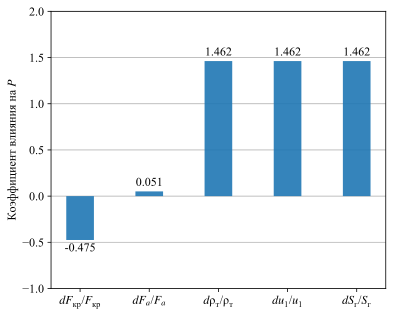

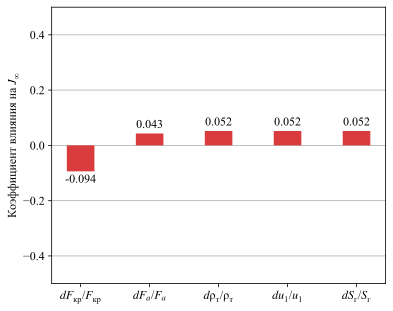

In [10]:
labels = ['$\mathit{dF}_{кр}$/$\mathit{F}_{кр}$', '$\mathit{dF_a}$/$\mathit{F_a}$',
        '$\mathit{d}\\rho_{т}$/$\\rho_{т}$', '$\mathit{du}_1$/$\mathit{u}_1$', '$\mathit{dS}_г$/$\mathit{S}_г$']
dP1s = np.round([dP_P(dF_kr=0.01)*100, dP_P(dF_a=0.01)*100, 
                dP_P(drho_t=0.01)*100, dP_P(du1=0.01)*100, dP_P(dS=0.01)*100],3)
dJ1s = np.round([dJ_J(dF_kr=0.01)*100, dJ_J(dF_a=0.01)*100, 
                dJ_J(drho_t=0.01)*100, dJ_J(du1=0.01)*100, dJ_J(dS=0.01)*100],3)

bar_plot(dP1s,'$\mathit{P}$',labels,filename='dP_P.svg')
bar_plot(dJ1s,'$\mathit{J}_{\\infty}$',labels,'tab:red','dJ_J.svg')

In [11]:
dP_P(0.01)*100

-0.47499368628069183

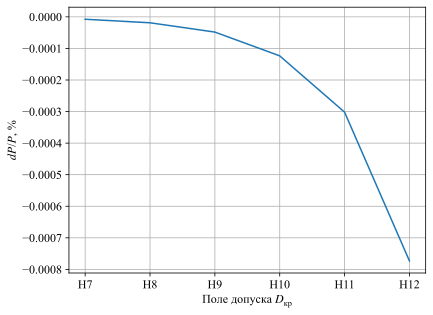

In [12]:
# влияние диаметра крритики на тягу
kvalD_kr = range(7,13)
dF_krs = [(get_dopusk(D_kr,kval) / D_kr)**2 for kval in kvalD_kr]
dPFs = [dP_P(dF_kr,0,0,0,0)*100 for dF_kr in dF_krs]

plt.plot(kvalD_kr,dPFs)
plt.xlabel('Поле допуска $\mathit{D}_{кр}$')
plt.ylabel('$\mathit{dP}$/$\mathit{P}$, %')
plt.xticks(ticks = kvalD_kr,labels=[f'H{kval}' for kval in kvalD_kr])
plt.grid()
# plt.savefig('D_kr.svg', dpi=300, bbox_inches='tight')
plt.show()

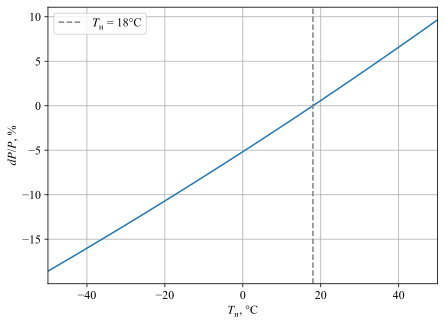

In [13]:
# влияние температуры на тягу
def du1f(T_n):
    """Отклонение единичной скорости горения от начальной температуры заряда

    Args:
        T_n (float): начальная температура заряда, К

    Returns:
        float: отклонение единичной скорости
    """
    return (np.exp(D_t*(T_n - 291.15)) - 1)

Ts = np.linspace(-50,50,100)
dPTs = [dP_P(du1=du1f(T_n + 273.15))*100 for T_n in Ts]

plt.figure(figsize=(7,5))
plt.plot(Ts,dPTs)
plt.axvline(18, ls = '--', c = 'grey',label = '$\mathit{T}_н$ = 18°C')
plt.xlabel('$\mathit{T}_н$, °C')
plt.ylabel('$\mathit{dP}$/$\mathit{P}$, %')
plt.xlim(-50,50)
plt.grid()
plt.legend()
# plt.savefig('T_n.svg', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
dPTs[-1]

9.661100381989687

In [15]:
def dS_g(dD = 0, dL = 0, dtheta = 0, dr = 0):
    # параметры: D_v, L_zar, theta, r
    D_v_new = (1 + dD) * D_v
    L_zar_new = (1 + dL) * L_zar
    theta_new = (1 + dtheta) * theta
    r_new = (1 + dr) * r
    S_g_new = zvezda(D_v_new,L_zar_new,e0,n_zv,theta_new,r_new)
    return (S_g_new - S_g) / S_g

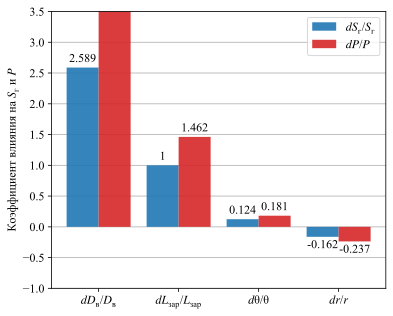

In [16]:
labelss = ['$\mathit{dD}_в$/$\mathit{D}_в$','$\mathit{dL}_{зар}$/$\mathit{L}_{зар}$',
            '$\mathit{d}\\theta$/$\\theta$','$\mathit{dr}$/$\mathit{r}$']

dS_gs = np.round([dS_g(dD=0.01)*100,dS_g(dL=0.01)*100,dS_g(dtheta=0.01)*100,dS_g(dr=0.01)*100],3)
dPSgs = np.round([dP_P(dS=dS_gi) for dS_gi in dS_gs],3)

x = np.arange(len(labelss))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(6,5))
rects1 = ax.bar(x - width/2, dS_gs, width,alpha = 0.9,color = 'tab:blue',zorder = 2,label = '$\mathit{dS}_г$/$\mathit{S}_г$')
rects2 = ax.bar(x + width/2, dPSgs, width,alpha = 0.9,color = 'tab:red',zorder = 2,label = '$\mathit{dP}$/$\mathit{P}$')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Коэффициент влияния на $\mathit{S}_г$ и $\mathit{P}$')
ax.set_xticks(x, labelss)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

# fig.tight_layout()
plt.ylim(-1,3.5)
plt.grid(axis='y',zorder = 1)
plt.legend()

# plt.savefig('dS_g.svg', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
dtheta = (1 / 6) / np.rad2deg(theta)
dr = get_dopusk(r,11) / r
dP_P(0,0,0,0,dS_g(dtheta=dtheta))*100

0.07730620726045996

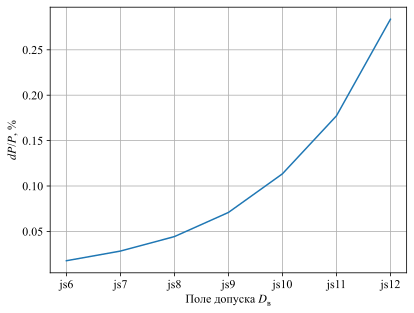

In [18]:
kvalD_v = range(6,13)
dD_vs = [get_dopusk(D_v,kval) / D_v/2 for kval in kvalD_v]
dPDs = [dP_P(0,0,0,0,dS_g(dD_v))*100 for dD_v in dD_vs]

plt.plot(kvalD_v,dPDs)
plt.plot()
plt.xlabel('Поле допуска $\mathit{D}_{в}$')
plt.ylabel('$\mathit{dP}$/$\mathit{P}$, %')
plt.xticks(ticks = kvalD_v,labels=[f'js{kval}' for kval in kvalD_v])
plt.grid()
# plt.savefig('D_v.svg', dpi=300, bbox_inches='tight')
plt.show()

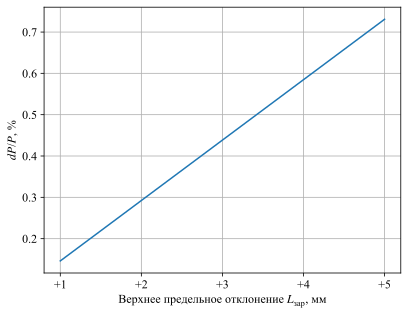

In [19]:
dL_zars = np.linspace(1e-3,5e-3,5)
dPLs = [dP_P(0,0,0,0,dS_g(dL=dL_zar))*100 for dL_zar in dL_zars]

plt.plot(dL_zars*1e3,dPLs)
plt.xlabel('Верхнее предельное отклонение $\mathit{L}_{зар}$, мм')
plt.ylabel('$\mathit{dP}$/$\mathit{P}$, %')
plt.xticks(ticks = dL_zars*1e3,labels=[f'+{kval*1e3:.0f}' for kval in dL_zars])
plt.grid()
# plt.savefig('L_zar.svg', dpi=300, bbox_inches='tight')
plt.show()

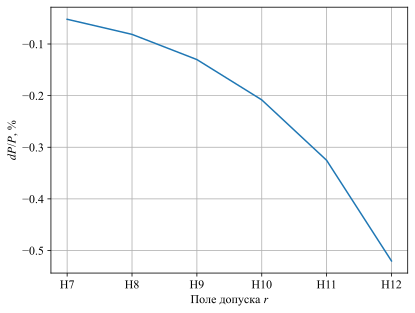

In [20]:
kvalr = range(7,13)
drs = [get_dopusk(r,kval) / r for kval in kvalr]
dPrs = [dP_P(0,0,0,0,dS_g(dr=dr))*100 for dr in drs]

plt.plot(kvalD_kr,dPrs)
plt.plot()
plt.xlabel('Поле допуска $\mathit{r}$')
plt.ylabel('$\mathit{dP}$/$\mathit{P}$, %')
plt.xticks(ticks = kvalr,labels=[f'H{kval}' for kval in kvalr])
plt.grid()
# plt.savefig('r.svg', dpi=300, bbox_inches='tight')
plt.show()

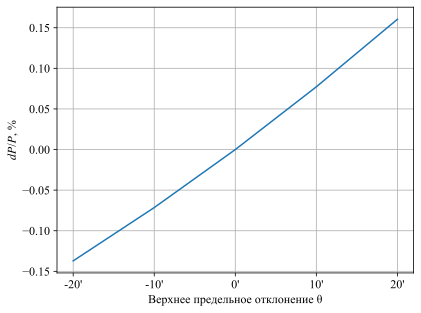

In [21]:
dthetas = np.linspace(-20,20,5)
dPts = [dP_P(0,0,0,0,dS_g(dtheta=np.deg2rad(dtheta/60)/theta))*100 for dtheta in dthetas]

plt.plot(dthetas,dPts)
plt.xlabel('Верхнее предельное отклонение $\\theta$')
plt.ylabel('$\mathit{dP}$/$\mathit{P}$, %')
plt.xticks(ticks = dthetas,labels=[f'{dtheta:.0f}\'' for dtheta in dthetas])
plt.grid()
# plt.savefig('theta.svg', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# задание константных отклонений

drho_t = 5 / rho_t
dF_a = (get_dopusk(D_a,12)/D_a)**2

# рассчитывем отклонение скорости, которое вызывает 3% отклонение тяги
du1 = 0.03 * (R_a - p_n * F_a) * (1 - mu_t) / R_a

# диапазон статической чувствительности
def get_diap_dP(T_n = 18 + 273.15):
    v = {
        'dF_kr': 0,
        'dF_a': (get_dopusk(D_a,12)/D_a)**2,
        'drho_t': 5 / rho_t,
        'du1': 0.03 * (R_a - p_n * F_a) * (1 - mu_t) / R_a + du1f(T_n),
        'dS': dS_g(get_dopusk(D_v,7) / D_v/2,3e-3/L_zar,-np.deg2rad(1/6)/theta,0)
    }
    n = {
        'dF_kr': (get_dopusk(D_kr,11)/D_kr)**2,
        'dF_a': 0,
        'drho_t': -5 / rho_t,
        'du1': du1f(T_n),
        'dS': dS_g(-get_dopusk(D_v,7) / D_v/2,-3e-3/L_zar,np.deg2rad(1/6)/theta,get_dopusk(r,10) / r)
    }
    return (dP_P(**n)*100,dP_P(**v)*100), dJ_J(**v)*100

In [23]:
dJ_J(dF_kr=get_dopusk(D_kr,11)**2)*100

-3.851837347564409e-07

In [24]:
def get_tabl(foo,kval_D_kr,kval_D_a,dop_rho_t,kval_D_v,dop_L_zar,kval_r,dop_theta):
    df_min = [foo(dF_kr=get_dopusk(D_kr,kval_D_kr)**2)*100,
             0,
             foo(du1=-du1)*100,
             foo(du1=du1f(-50+273.15))*100,
             foo(drho_t=-dop_rho_t/rho_t)*100,
             foo(dS=dS_g(dD=-get_dopusk(D_v,kval_D_v)/2))*100,
             foo(dS=dS_g(dL=-dop_L_zar/L_zar))*100,
             foo(dS=dS_g(dr=get_dopusk(r,kval_r)))*100,
             foo(dS=dS_g(dtheta=dop_theta/theta))*100]
    df_min.append(sum(df_min))
    
    df_max = [0,
             foo(dF_a=get_dopusk(D_a,kval_D_a)**2)*100,
             foo(du1=du1)*100,
             foo(du1=du1f(50+273.15))*100,
             foo(drho_t=dop_rho_t/rho_t)*100,
             foo(dS=dS_g(dD=get_dopusk(D_v,kval_D_v)/2))*100,
             foo(dS=dS_g(dL=dop_L_zar/L_zar))*100,
             0,
             foo(dS=dS_g(dtheta=-dop_theta/theta))*100]
    df_max.append(sum(df_max))
    
    pars = ['D_kr','D_a','u1(хим)','u1(T)','rho_t','D_v','L_zar','r','theta','сум']
    
    df = pd.DataFrame({'min':df_min,'max':df_max},index=pars)
    display(df)

In [25]:
vars = {
    'kval_D_kr': 11,
    'kval_D_a': 11,
    'dop_rho_t': 5,
    'kval_D_v': 6,
    'dop_L_zar': 2e-3,
    'kval_r': 9,
    'dop_theta': np.deg2rad(20/60)
}

print('dP_P')
get_tabl(dP_P,**vars)

print('dJ_J')
get_tabl(dJ_J,**vars)

dP_P


,min,max
D_kr,-0.000002,0.000000e+00
D_a,0.000000,6.133759e-07
u1(хим),-3.000000,3.000000e+00
u1(T),-18.587313,9.661100e+00
rho_t,-0.429423,4.294232e-01
D_v,-0.006878,6.939433e-03
L_zar,-0.102114,1.021136e-01
r,-0.000754,0.000000e+00
theta,0.160449,-1.370580e-01
сум,-21.966034,1.306252e+01


dJ_J


,min,max
D_kr,-3.851837e-07,0.000000e+00
D_a,0.000000e+00,5.109666e-07
u1(хим),-1.064066e-01,1.064066e-01
u1(T),-6.592708e-01,3.426682e-01
rho_t,-1.523115e-02,1.523115e-02
D_v,-2.439404e-04,2.461338e-04
L_zar,-3.621854e-03,3.621854e-03
r,-2.675374e-05,0.000000e+00
theta,5.690946e-03,-4.861290e-03
сум,-7.791106e-01,4.633132e-01
